# Data Augmentation

In [10]:
# imports
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd

# get data
!wget --no-check-certificate \
    -O /tmp/sentiment.csv https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P

# define get_data function
def get_data(path):
  data = pd.read_csv(path, index_col=0)
  return data

#get the data
data = get_data('/tmp/sentiment.csv')

# clone package repository
!git clone https://github.com/vallantin/atalaia.git

# navigate to atalaia directory
%cd atalaia

# install packages requirements
!pip install -r requirements.txt

# install package
!python setup.py install

# import it
from atalaia.atalaia import Atalaia

--2020-07-08 07:52:54--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 173.194.197.101, 173.194.197.102, 173.194.197.139, ...
Connecting to drive.google.com (drive.google.com)|173.194.197.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/p8030o4oecsm7hg1mg8doqjggak81hdo/1594194750000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P [following]
--2020-07-08 07:52:55--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/p8030o4oecsm7hg1mg8doqjggak81hdo/1594194750000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 172.217.212.132, 2607:f8b0:4001:c03::84
Connecting to doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)|1

Preprocess data.

In [11]:
#def pre-process function
def preprocess(panda_series):
  atalaia = Atalaia('en')

  # lower case everyting and remove double spaces
  panda_series = [atalaia.lower_remove_white(t) for t in panda_series]

  # expand contractions
  panda_series = [atalaia.expand_contractions(t) for t in panda_series]

  # remove punctuation
  panda_series = [atalaia.remove_punctuation(t) for t in panda_series]

  # remove numbers
  panda_series = [atalaia.remove_numbers(t) for t in panda_series]

  # remove stopwords
  panda_series = [atalaia.remove_stopwords(t) for t in panda_series]

  # remove excessive spaces
  panda_series = [atalaia.remove_excessive_spaces(t) for t in panda_series]

  return panda_series

# preprocess it
preprocessed_text = preprocess(data.text)

Replace tokenizer with subwords tokenizer

In [12]:
# get a smaller vocab size
vocab_size = 1000

# define the maximum size of a subword
sub_length = 5

# out of vocabulary replacement
oov_tok = "<OOV>"
import tensorflow_datasets as tfds

# start tokenize
tokenizer = Tokenizer(num_words=vocab_size, 
                      oov_token=oov_tok)

tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(preprocessed_text, 
                                                                    vocab_size, 
                                                                    max_subword_length=sub_length)

# encode the whole dataset
encoded_texts = [tokenizer.encode(sentence) for sentence in preprocessed_text]

Visualize what's happening:

In [13]:
# get the first encoded sentence to see what this tokenizer does
view = [tokenizer.decode([i]) for i in encoded_texts[0]]
view = ' '.join(view)
view

'so  there   is  no  way  for  me  plug   it  in  here  in  us  un less  i  go  by  con ver ter'

Let's pad everything and split into test and train. To keep things simple, we won't try to balance the dataset.

In [14]:
# pad sequences and split into test and train
max_length = 100
trunc_type='post'
padding_type='post'

# Pad all sentences
sentences_padded = pad_sequences(encoded_texts, 
                                 maxlen=max_length, 
                                 padding=padding_type, 
                                 truncating=trunc_type)

# get the labels
labels  = data.sentiment

# Separate out the sentences and labels into training and test sets
size    = int(len(data.text) * 0.8)

X_train = sentences_padded[0:size]
X_test  = sentences_padded[size:]
y_train = labels[0:size]
y_test  = labels[size:]

# Convert labels to Numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)


Finally, let's get a smaller dimensional space and compile the model. 

In [24]:
# Build network
embedding_dim = 16

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 16)           16000     
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 102       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 16,109
Trainable params: 16,109
Non-trainable params: 0
_________________________________________________________________


In [25]:
# train the model
num_epochs = 23
history = model.fit(X_train, 
                    y_train, 
                    epochs=num_epochs,
                    validation_data=(X_test, y_test))
    


Epoch 1/23
50/50 [==============================] - 0s 8ms/step - loss: 0.6931 - accuracy: 0.5122 - val_loss: 0.6942 - val_accuracy: 0.4110
Epoch 2/23
50/50 [==============================] - 0s 6ms/step - loss: 0.6928 - accuracy: 0.5223 - val_loss: 0.6951 - val_accuracy: 0.4110
Epoch 3/23
50/50 [==============================] - 0s 6ms/step - loss: 0.6926 - accuracy: 0.5223 - val_loss: 0.6961 - val_accuracy: 0.4110
Epoch 4/23
50/50 [==============================] - 0s 7ms/step - loss: 0.6925 - accuracy: 0.5223 - val_loss: 0.6970 - val_accuracy: 0.4110
Epoch 5/23
50/50 [==============================] - 0s 6ms/step - loss: 0.6924 - accuracy: 0.5223 - val_loss: 0.6976 - val_accuracy: 0.4110
Epoch 6/23
50/50 [==============================] - 0s 6ms/step - loss: 0.6922 - accuracy: 0.5348 - val_loss: 0.6934 - val_accuracy: 0.4311
Epoch 7/23
50/50 [==============================] - 0s 7ms/step - loss: 0.6905 - accuracy: 0.5311 - val_loss: 0.6898 - val_accuracy: 0.6642
Epoch 8/23
50/50 [==

Now, we can plot accuracy and loss

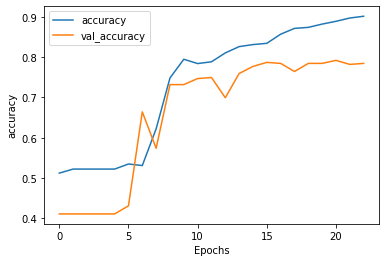

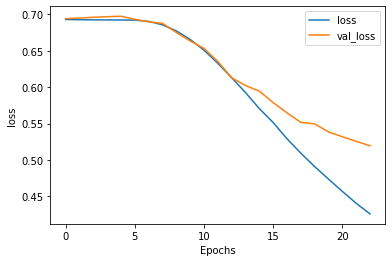

In [26]:
def plots(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plots(history, "accuracy")
plots(history, "loss")

In [27]:
accuracy = model.evaluate(X_test, y_test)[1]
print('Model accuracy is {:.2f}%'.format(accuracy*100))

13/13 [==============================] - 0s 2ms/step - loss: 0.5193 - accuracy: 0.7845
Model accuracy is 78.45%
